In the ever-evolving landscape of cybersecurity, network intrusion detection has become the frontline defense for protecting digital assets from a constant barrage of threats. Traditional, signature-based Intrusion Detection Systems (IDS) have proven to be increasingly insufficient, struggling to identify novel or zero-day attacks that do not match a pre-defined signature. This critical vulnerability necessitates a more intelligent, adaptive defense mechanism—one that can learn and generalize from network traffic patterns to identify malicious behavior, known or unknown.

Our research addresses this very challenge by leveraging a robust machine learning approach. By moving beyond static rules, we seek to create an IDS capable of dynamically discerning benign network activity from the subtle anomalies indicative of an attack. This is our story: a journey into data-driven network defense, using the widely recognized UNSW-NB15 dataset, which is celebrated for its realistic blend of modern normal and synthetic contemporary attack scenarios.


Before any meaningful analysis can begin, the right tools must be assembled. Our computational environment is prepared with a suite of essential libraries, each playing a specific role in the machine learning pipeline. This initial code block represents the foundational setup, a declaration of the methods and metrics that will guide our investigation.

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from collections import Counter
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.metrics import precision_recall_curve, average_precision_score, f1_score


import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
pd.set_option('display.float_format', lambda x: '%.3f' % x)
plt.rcParams["figure.figsize"] = (10,6)

At its core, this code block outlines the methodological framework for our study. We begin by importing pandas and numpy, the industry standards for data manipulation and numerical operations, which will be used to structure and process the raw network traffic data. Data visualization is also a critical component for exploratory analysis and presenting results, so we incorporate matplotlib.pyplot and seaborn. These libraries will allow us to illustrate key data characteristics, such as class distribution, and evaluate model performance with clear, intuitive plots.


The sklearn library is the central engine for our machine learning implementation. LabelEncoder is a crucial component for converting categorical target labels (e.g., 'Normal' or 'Attack') into a machine-readable numerical format. MinMaxScaler is selected for feature scaling, a standard procedure that normalizes the range of our features to prevent any single attribute from disproportionately influencing the model.

One of the well-documented challenges in building an effective IDS, especially with the UNSW-NB15 dataset, is the significant class imbalance between normal and attack traffic. To counter this, we proactively import SMOTE (imblearn.over_sampling), a technique designed to synthesize new, representative samples for minority classes. This strategic step is vital for ensuring our model does not become biased towards the more prevalent "normal" traffic.


For the core of our detection model, we choose RandomForestClassifier. This ensemble method, known for its robustness and ability to handle high-dimensional data, is a strong candidate for distinguishing complex intrusion patterns. Furthermore, to find the optimal set of hyperparameters for our classifier, we will use RandomizedSearchCV from sklearn.model_selection. This pragmatic approach allows us to efficiently search a large parameter space, maximizing model performance without an exhaustive, time-consuming grid search.

Finally, we establish a comprehensive set of evaluation metrics—classification_report, confusion_matrix, roc_auc_score, roc_curve, precision_recall_curve, average_precision_score, and f1_score. These are the yardsticks by which we will measure our model's success. By including a diverse range of metrics, we ensure a holistic assessment of the model's predictive capabilities, addressing not just overall accuracy but also the critical trade-offs between precision and recall, which is paramount in intrusion detection where false negatives (missed attacks) can have severe consequences. The final lines of code are focused on setting up a clean, consistent display environment, ensuring our subsequent results are presented with clarity and professional formatting.

For this study, we utilize the UNSW-NB15 dataset, a robust benchmark for modern network intrusion detection. Created at the University of New South Wales, it contains a mix of real network traffic and synthesized contemporary attack data.
Our initial step, shown below, loads the pre-defined training and testing sets into pandas DataFrames, ensuring a standardized and fair evaluation process. A copy of the training data is made for preprocessing, and the df.head() command provides a crucial first look at the data's structure. This preview reveals key features like dur, proto, and the critical attack_cat and label columns, which distinguish between normal and malicious traffic. This data-loading and inspection process is the foundation for our rigorous, data-driven approach.

In [4]:
df_train = pd.read_csv("./dataset/UNSW_NB15_training-set.csv")
df_test = pd.read_csv("./dataset/UNSW_NB15_testing-set.csv")
df= df_train.copy()
df.head()

,id,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,rate,...,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,attack_cat,label
0,1,0.000,udp,-,INT,2,0,496,0,90909.090,...,1,2,0,0,0,1,2,0,Normal,0
1,2,0.000,udp,-,INT,2,0,1762,0,125000.000,...,1,2,0,0,0,1,2,0,Normal,0
2,3,0.000,udp,-,INT,2,0,1068,0,200000.005,...,1,3,0,0,0,1,3,0,Normal,0
3,4,0.000,udp,-,INT,2,0,900,0,166666.661,...,1,3,0,0,0,2,3,0,Normal,0
4,5,0.000,udp,-,INT,2,0,2126,0,100000.003,...,1,3,0,0,0,2,3,0,Normal,0


The resulting `df.head()` output offers a snapshot of our dataset's composition:

- **Feature diversity:**  
  It shows a mix of numerical features (`dur`, `spkts`, `sbytes`) and categorical features (`proto`, `service`, `state`).  
  This mixture necessitates specific preprocessing steps to handle both data types effectively.

- **Target variables:**  
  The presence of both `attack_cat` (multi-class attack types like *Normal*, *Fuzzers*) and a binary `label` (0 for normal, 1 for attack) indicates that the dataset can be used for both fine-grained and simpler intrusion detection tasks.

- **Initial data state:**  
  Observing `df.head()` allows for an early check for obvious data issues, ensuring that the next stages of preprocessing are well-informed.


## Initial Data Assessment

Following the loading of the UNSW-NB15 dataset, a fundamental step in any data-driven research project is to perform an initial data assessment. The `df.info()` command provides a high-level summary of the dataset's structure, offering crucial insights into data types, potential missing values, and memory footprint. This quick diagnostic check allows us to form a strategy for the subsequent data preprocessing and cleaning stages.


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 82332 entries, 0 to 82331
Data columns (total 45 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 82332 non-null  int64  
 1   dur                82332 non-null  float64
 2   proto              82332 non-null  object 
 3   service            82332 non-null  object 
 4   state              82332 non-null  object 
 5   spkts              82332 non-null  int64  
 6   dpkts              82332 non-null  int64  
 7   sbytes             82332 non-null  int64  
 8   dbytes             82332 non-null  int64  
 9   rate               82332 non-null  float64
 10  sttl               82332 non-null  int64  
 11  dttl               82332 non-null  int64  
 12  sload              82332 non-null  float64
 13  dload              82332 non-null  float64
 14  sloss              82332 non-null  int64  
 15  dloss              82332 non-null  int64  
 16  sinpkt             823

## Statistical Landscape of Numerical Features

Following the initial data overview, a deeper dive into the statistical properties of the numerical features is indispensable. The `df.describe()` method serves as a powerful instrument for this purpose, providing a concise summary of the central tendency, dispersion, and shape of each numerical feature's distribution. Understanding these characteristics is crucial for identifying potential outliers, assessing feature scales, and devising appropriate preprocessing strategies.


In [6]:
df_train.describe()

,id,dur,spkts,dpkts,sbytes,dbytes,rate,sttl,dttl,sload,...,ct_src_dport_ltm,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,label
count,82332.000,82332.000,82332.000,82332.000,82332.000,82332.000,82332.000,82332.000,82332.000,82332.000,...,82332.000,82332.000,82332.000,82332.000,82332.000,82332.000,82332.000,82332.000,82332.000,82332.000
mean,41166.500,1.007,18.666,17.546,7993.908,13233.786,82410.887,180.968,95.713,64549016.914,...,4.929,3.663,7.456,0.008,0.008,0.130,6.468,9.164,0.011,0.551
std,23767.346,4.710,133.916,115.574,171642.262,151471.456,148620.367,101.513,116.668,179861832.630,...,8.390,5.915,11.415,0.091,0.092,0.639,8.544,11.121,0.105,0.497
min,1.000,0.000,1.000,0.000,24.000,0.000,0.000,0.000,0.000,0.000,...,1.000,1.000,1.000,0.000,0.000,0.000,1.000,1.000,0.000,0.000
25%,20583.750,0.000,2.000,0.000,114.000,0.000,28.606,62.000,0.000,11202.467,...,1.000,1.000,1.000,0.000,0.000,0.000,1.000,2.000,0.000,0.000
50%,41166.500,0.014,6.000,2.000,534.000,178.000,2650.177,254.000,29.000,577003.219,...,1.000,1.000,3.000,0.000,0.000,0.000,3.000,5.000,0.000,1.000
75%,61749.250,0.719,12.000,10.000,1280.000,956.000,111111.107,254.000,252.000,65142856.000,...,4.000,3.000,6.000,0.000,0.000,0.000,7.000,11.000,0.000,1.000
max,82332.000,60.000,10646.000,11018.000,14355774.000,14657531.000,1000000.003,255.000,253.000,5268000256.000,...,59.000,38.000,63.000,2.000,2.000,16.000,60.000,62.000,1.000,1.000


## Checking for Missing Values

The pandas command `df_train.isnull().sum()` is used to count the number of missing values in each column of the DataFrame `df_train`.  

### How it works
- **`df_train.isnull()`**:  
  Returns a new DataFrame of the same size as `df_train`, but with boolean values.  
  - `True` → indicates a missing or null value (`NaN`, `None`)  
  - `False` → indicates a non-missing value  

- **`.sum()`**:  
  This method is then called on the boolean DataFrame. In Python, when arithmetic operations are performed on boolean values:  
  - `True` is treated as **1**  
  - `False` is treated as **0**  

Thus, `.sum()` adds up the `True` values in each column.  


In [7]:
df_train.isnull().sum()

id                   0
dur                  0
proto                0
service              0
state                0
spkts                0
dpkts                0
sbytes               0
dbytes               0
rate                 0
sttl                 0
dttl                 0
sload                0
dload                0
sloss                0
dloss                0
sinpkt               0
dinpkt               0
sjit                 0
djit                 0
swin                 0
stcpb                0
dtcpb                0
dwin                 0
tcprtt               0
synack               0
ackdat               0
smean                0
dmean                0
trans_depth          0
response_body_len    0
ct_srv_src           0
ct_state_ttl         0
ct_dst_ltm           0
ct_src_dport_ltm     0
ct_dst_sport_ltm     0
ct_dst_src_ltm       0
is_ftp_login         0
ct_ftp_cmd           0
ct_flw_http_mthd     0
ct_src_ltm           0
ct_srv_dst           0
is_sm_ips_ports      0
attack_cat 

## Characterizing the Categorical Landscape

In addition to numerical features, the UNSW-NB15 dataset includes critical categorical features such as `proto` (protocol), `service` (application layer service), `state` (connection state), and `attack_cat` (attack category). Unlike their numerical counterparts, these features hold qualitative information that must be understood and processed differently.  

The `value_counts()` function from the **pandas** library is an essential tool for this, providing a frequency distribution that reveals the balance and diversity within each categorical feature.  

This step is vital for uncovering potential data imbalances and guiding the choice of appropriate encoding techniques.


In [8]:
df_train['proto'].value_counts()
df_train['service'].value_counts()
df_train['state'].value_counts()
df_train['attack_cat'].value_counts()

attack_cat
Normal            37000
Generic           18871
Exploits          11132
Fuzzers            6062
DoS                4089
Reconnaissance     3496
Analysis            677
Backdoor            583
Shellcode           378
Worms                44
Name: count, dtype: int64

## Data Cleaning and Pre-processing

In [9]:
df_train['service'].fillna('unknown', inplace=True)
df_test['service'].fillna('unknown', inplace=True)


Encode the nominal categorical features (proto, service, state, and attack_cat) using OneHotEncoder. This converts them into a numerical format that models can understand.

In [10]:

df_train_copy = df_train.copy()
df_test_copy = df_test.copy()

categorical_cols = ['proto', 'service', 'state']


df_train_encoded = pd.get_dummies(df_train_copy, columns=categorical_cols, dtype=int)
df_test_encoded = pd.get_dummies(df_test_copy, columns=categorical_cols, dtype=int)


le = LabelEncoder()
df_train_encoded['attack_cat_encoded'] = le.fit_transform(df_train_encoded['attack_cat'])
df_test_encoded['attack_cat_encoded'] = le.transform(df_test_encoded['attack_cat'])

print("Columns after encoding in df_train_encoded:", df_train_encoded.columns)


Columns after encoding in df_train_encoded: Index(['id', 'dur', 'spkts', 'dpkts', 'sbytes', 'dbytes', 'rate', 'sttl',
       'dttl', 'sload',
       ...
       'service_ssh', 'service_ssl', 'state_ACC', 'state_CLO', 'state_CON',
       'state_FIN', 'state_INT', 'state_REQ', 'state_RST',
       'attack_cat_encoded'],
      dtype='object', length=194)


## Feature Scaling and Dataset Alignment

Following our examination of the data's statistical and categorical properties, the next crucial step is to prepare the numerical features for the machine learning algorithm. As seen in the statistical summary, many numerical features in the **UNSW-NB15 dataset** have vastly different scales. Features like `rate` and `sbytes` can have values orders of magnitude larger than features like `dur`. This disparity can cause algorithms, particularly distance-based ones, to be disproportionately influenced by features with larger values.  

To mitigate this, we employ **MinMaxScaler** to normalize our numerical features, re-scaling their values to a fixed range between **0 and 1**. This ensures that all features contribute equally to the model's learning process, leading to a more balanced and effective classifier.  

A secondary, but equally important, part of this process is ensuring the **structural consistency** of our training and testing datasets. Categorical encoding can sometimes produce different sets of columns (e.g., due to different unique categories) in the training and testing data. This misalignment must be addressed to prevent errors during the prediction phase.


In [11]:

numerical_cols = ['dur', 'spkts', 'dpkts', 'sbytes', 'dbytes', 'rate', 
                  'ct_dst_sport_ltm', 'ct_dst_src_ltm', 'ct_src_ltm', 'ct_srv_dst']

scaler = MinMaxScaler()
df_train_encoded[numerical_cols] = scaler.fit_transform(df_train_encoded[numerical_cols])
df_test_encoded[numerical_cols] = scaler.transform(df_test_encoded[numerical_cols])

train_cols = set(df_train_encoded.columns)
test_cols = set(df_test_encoded.columns)


for col in train_cols - test_cols:
    df_test_encoded[col] = 0
for col in test_cols - train_cols:
    df_train_encoded[col] = 0


df_test_encoded = df_test_encoded[df_train_encoded.columns]

## Addressing Class Imbalance with SMOTE

The UNSW-NB15 dataset, like most real-world network traffic data, is characterized by a severe class imbalance. This phenomenon occurs because benign network traffic overwhelmingly outnumbers malicious attack instances. If a model is trained on this skewed distribution without intervention, it will become biased towards the majority *normal* class, leading to poor performance in detecting rare but critical attack types. To build a robust Intrusion Detection System, this issue must be addressed proactively.  

Our solution is to employ the **Synthetic Minority Over-sampling Technique (SMOTE)**. SMOTE is an oversampling method that creates **synthetic, yet plausible, data points** for the minority class, effectively balancing the class distribution.  

**How it works:**  
- Selects a **minority class instance**  
- Finds its **nearest neighbors**  
- Generates a new, synthetic sample somewhere along the **line segment connecting the instance and its neighbor**  

This process enriches the minority class with new, similar examples, allowing the model to learn its patterns more effectively without simply duplicating existing data.


In [12]:
print(df_train.columns)

Index(['id', 'dur', 'proto', 'service', 'state', 'spkts', 'dpkts', 'sbytes',
       'dbytes', 'rate', 'sttl', 'dttl', 'sload', 'dload', 'sloss', 'dloss',
       'sinpkt', 'dinpkt', 'sjit', 'djit', 'swin', 'stcpb', 'dtcpb', 'dwin',
       'tcprtt', 'synack', 'ackdat', 'smean', 'dmean', 'trans_depth',
       'response_body_len', 'ct_srv_src', 'ct_state_ttl', 'ct_dst_ltm',
       'ct_src_dport_ltm', 'ct_dst_sport_ltm', 'ct_dst_src_ltm',
       'is_ftp_login', 'ct_ftp_cmd', 'ct_flw_http_mthd', 'ct_src_ltm',
       'ct_srv_dst', 'is_sm_ips_ports', 'attack_cat', 'label'],
      dtype='object')


In [13]:

X = df_train_encoded.drop(['id', 'label', 'attack_cat', 'attack_cat_encoded'], axis=1)
y = df_train_encoded['attack_cat_encoded']


print('Original class distribution:', Counter(y))

smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

print('Resampled class distribution:', Counter(y_resampled))


Original class distribution: Counter({6: 37000, 5: 18871, 3: 11132, 4: 6062, 2: 4089, 7: 3496, 0: 677, 1: 583, 8: 378, 9: 44})


  File "c:\Users\Chibueze\dev\Anigbogu\ddos-detector\.venv\Lib\site-packages\joblib\externals\loky\backend\context.py", line 247, in _count_physical_cores
    cpu_count_physical = _count_physical_cores_win32()
  File "c:\Users\Chibueze\dev\Anigbogu\ddos-detector\.venv\Lib\site-packages\joblib\externals\loky\backend\context.py", line 299, in _count_physical_cores_win32
    cpu_info = subprocess.run(
        "wmic CPU Get NumberOfCores /Format:csv".split(),
        capture_output=True,
        text=True,
    )
  File "C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.13_3.13.1008.0_x64__qbz5n2kfra8p0\Lib\subprocess.py", line 554, in run
    with Popen(*popenargs, **kwargs) as process:
         ~~~~~^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.13_3.13.1008.0_x64__qbz5n2kfra8p0\Lib\subprocess.py", line 1039, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
    ~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^

Resampled class distribution: Counter({6: 37000, 7: 37000, 1: 37000, 2: 37000, 3: 37000, 0: 37000, 4: 37000, 9: 37000, 8: 37000, 5: 37000})


To make your Random Forest Classifier more robust for network intrusion detection, especially given the imbalanced nature of the UNSW-NB15 dataset, you should go beyond the default settings. A robust approach involves three key strategies: hyperparameter tuning, using class weights, and implementing cross-validation. Instead of manually guessing the best parameters, use RandomizedSearchCV to efficiently find the optimal combination of hyperparameters. This is faster than GridSearchCV and often just as effective for large search spaces

In [14]:
X_subset, _, y_subset, _ = train_test_split(X_resampled, y_resampled, test_size=0.8, stratify=y_resampled, random_state=42)

param_dist = {
    'n_estimators': [50, 100, 200], # 300 400 500
    'max_features': ['sqrt', 'log2'],
    'max_depth': [10, 20, 30, None], # 40, 50
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False],
    'class_weight': ['balanced', 'balanced_subsample', None]
}

rf = RandomForestClassifier(random_state=42)


random_search = RandomizedSearchCV(estimator=rf, param_distributions=param_dist, n_iter=10, cv=5, verbose=2, random_state=42, n_jobs=1)

random_search.fit(X_subset, y_subset)

best_model = random_search.best_estimator_

print("Best parameters found: ", random_search.best_params_)


model = best_model
model.fit(X_resampled, y_resampled)


Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] END bootstrap=False, class_weight=None, max_depth=10, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   8.0s
[CV] END bootstrap=False, class_weight=None, max_depth=10, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   7.8s
[CV] END bootstrap=False, class_weight=None, max_depth=10, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   8.0s
[CV] END bootstrap=False, class_weight=None, max_depth=10, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   7.9s
[CV] END bootstrap=False, class_weight=None, max_depth=10, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   8.0s
[CV] END bootstrap=False, class_weight=balanced, max_depth=None, max_features=log2, min_samples_leaf=4, min_samples_split=5, n_estimators=200; total time=  36.

,n_estimators,50
,criterion,'gini'
,max_depth,30
,min_samples_split,10
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


## Model Evaluation and Performance Visualization

After meticulously preparing our data and addressing the class imbalance using **SMOTE**, the next pivotal step is to **evaluate the trained model's performance** on unseen data. It is imperative to assess how well our **Random Forest classifier** generalizes to new, previously unobserved network traffic.  

We achieve this by predicting on the dedicated **test dataset (`df_test_encoded`)**, ensuring an unbiased evaluation of the model's effectiveness in a **real-world scenario**.  

### Predicted Probabilities
Beyond simple predictions, we also extract the model's **predicted probabilities** for each class. This provides a deeper insight into the model's **confidence** for each classification, which can be invaluable for:  
- Fine-tuning the **decision threshold**  
- Applications where the **certainty of detection** is as important as the detection itself  

In [15]:
X_test = df_test_encoded.drop(['id', 'label', 'attack_cat', 'attack_cat_encoded'], axis=1)
y_test = df_test_encoded['attack_cat_encoded']

y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)


In [16]:

plt.style.use('default')
sns.set_palette("husl")

def plot_per_class_metrics(y_test, y_pred, class_names=None):
    """Plot per-class precision, recall, and F1-score"""
    from sklearn.metrics import precision_recall_fscore_support
    
    precision, recall, f1, support = precision_recall_fscore_support(y_test, y_pred)
    
    if class_names is None:
        class_names = [f'Class {i}' for i in range(len(precision))]
    
    x = np.arange(len(class_names))
    width = 0.25
    
    fig, ax = plt.subplots(figsize=(12, 6))
    ax.bar(x - width, precision, width, label='Precision', alpha=0.8)
    ax.bar(x, recall, width, label='Recall', alpha=0.8)
    ax.bar(x + width, f1, width, label='F1-Score', alpha=0.8)
    
    ax.set_xlabel('Attack Categories')
    ax.set_ylabel('Score')
    ax.set_title('Per-Class Performance Metrics')
    ax.set_xticks(x)
    ax.set_xticklabels(class_names, rotation=45, ha='right')
    ax.legend()
    ax.grid(axis='y', alpha=0.3)
    
    plt.tight_layout()
    plt.show()

def plot_precision_recall_multiclass(y_test, y_pred_proba, n_classes):
    """Plot Precision-Recall curves for each class"""
    from sklearn.preprocessing import label_binarize
    
    # Binarize the output
    y_test_bin = label_binarize(y_test, classes=range(n_classes))
    
    plt.figure(figsize=(12, 8))
    colors = plt.cm.Set1(np.linspace(0, 1, n_classes))
    
    for i in range(n_classes):
        precision, recall, _ = precision_recall_curve(y_test_bin[:, i], y_pred_proba[:, i])
        avg_precision = average_precision_score(y_test_bin[:, i], y_pred_proba[:, i])
        
        plt.plot(recall, precision, color=colors[i], lw=2,
                label=f'Class {i} (AP = {avg_precision:.2f})')
    
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curves by Attack Category')
    plt.legend(loc='lower left')
    plt.grid(alpha=0.3)
    plt.show()

def plot_feature_importance(model, feature_names, top_n=20):
    """Plot top N most important features"""
    importances = model.feature_importances_
    indices = np.argsort(importances)[::-1][:top_n]
    
    plt.figure(figsize=(12, 8))
    plt.title(f'Top {top_n} Feature Importances')
    plt.bar(range(top_n), importances[indices], alpha=0.7)
    plt.xticks(range(top_n), [feature_names[i] for i in indices], rotation=90)
    plt.ylabel('Importance Score')
    plt.xlabel('Features')
    plt.tight_layout()
    plt.show()

def plot_class_distribution_comparison(y_original, y_resampled, class_names=None):
    """Compare class distributions before and after SMOTE"""
    from collections import Counter
    
    original_counts = Counter(y_original)
    resampled_counts = Counter(y_resampled)
    
    if class_names is None:
        class_names = [f'Class {i}' for i in sorted(original_counts.keys())]
    
    classes = sorted(original_counts.keys())
    orig_values = [original_counts[c] for c in classes]
    resamp_values = [resampled_counts[c] for c in classes]
    
    x = np.arange(len(classes))
    width = 0.35
    
    fig, ax = plt.subplots(figsize=(12, 6))
    ax.bar(x - width/2, orig_values, width, label='Original', alpha=0.8)
    ax.bar(x + width/2, resamp_values, width, label='After SMOTE', alpha=0.8)
    
    ax.set_xlabel('Attack Categories')
    ax.set_ylabel('Number of Samples')
    ax.set_title('Class Distribution: Before vs After SMOTE')
    ax.set_xticks(x)
    ax.set_xticklabels(class_names, rotation=45, ha='right')
    ax.legend()
    ax.grid(axis='y', alpha=0.3)
    
    plt.tight_layout()
    plt.show()

def plot_learning_curves(model, X, y, cv=5):
    """Plot learning curves to show model performance vs training size"""
    from sklearn.model_selection import learning_curve
    
    train_sizes, train_scores, val_scores = learning_curve(
        model, X, y, cv=cv, n_jobs=-1, 
        train_sizes=np.linspace(0.1, 1.0, 10),
        scoring='f1_weighted'
    )
    
    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    val_mean = np.mean(val_scores, axis=1)
    val_std = np.std(val_scores, axis=1)
    
    plt.figure(figsize=(10, 6))
    plt.plot(train_sizes, train_mean, 'o-', color='blue', label='Training Score')
    plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1, color='blue')
    
    plt.plot(train_sizes, val_mean, 'o-', color='red', label='Cross-Validation Score')
    plt.fill_between(train_sizes, val_mean - val_std, val_mean + val_std, alpha=0.1, color='red')
    
    plt.xlabel('Training Set Size')
    plt.ylabel('F1-Score (Weighted)')
    plt.title('Learning Curves')
    plt.legend(loc='lower right')
    plt.grid(alpha=0.3)
    plt.show()


attack_categories = le.classes_ 


## Per-Class Performance Metrics

The function `plot_per_class_metrics(y_test, y_pred, class_names)` is designed to visualize **Precision**, **Recall**, and **F1-score** for each individual attack category.  

- **Precision**  
  Indicates the accuracy of positive predictions.  
  *Example:* How many predicted *Fuzzers* were actually *Fuzzers*.  

- **Recall**  
  Measures the model's ability to identify all positive instances.  
  *Example:* How many actual *Fuzzers* were correctly identified.  

- **F1-Score**  
  The harmonic mean of Precision and Recall. This is particularly important for **imbalanced datasets**, as it provides a balanced measure of classification performance.  

### Importance of Per-Class Visualization
Visualizing these metrics per-class is vital for:  
- Understanding which attack types the IDS **excels at detecting**  
- Identifying attack types where performance is **weak**  
- Guiding **future improvements** in model design  

As noted by Evidently AI, such granular analysis is crucial:  
- In one case, **Class “B”** showed worse Recall and Precision,  
- While **Class “A”** performed significantly better.  


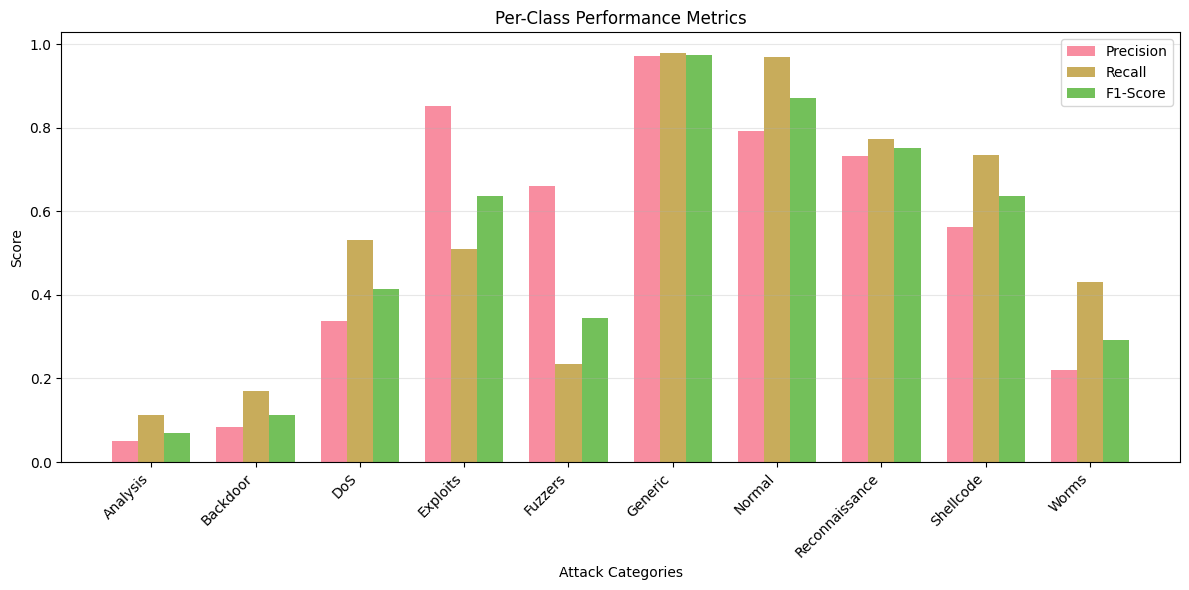

In [17]:
# Per-class metrics
plot_per_class_metrics(y_test, y_pred, attack_categories)

### `plot_precision_recall_multiclass(y_test, y_pred_proba, n_classes)`

This function generates Precision-Recall (PR) curves for each class, illustrating the trade-off between precision and recall across varying classification thresholds.  

- Precision: The proportion of true positives among all positive predictions.  
- Recall: The proportion of true positives correctly identified among all actual positives.  

A higher Area Under the Precision-Recall Curve (AUPRC) signifies better model performance. Importantly, the PR curve is often considered more reliable than the ROC curve for **imbalanced datasets**, as it emphasizes performance on the positive class.  

According to **Scikit-learn**, these curves provide valuable insights into how the classifier performs across different thresholds, helping identify optimal trade-offs for intrusion detection scenarios where missing attacks can be far more costly than false alarms.


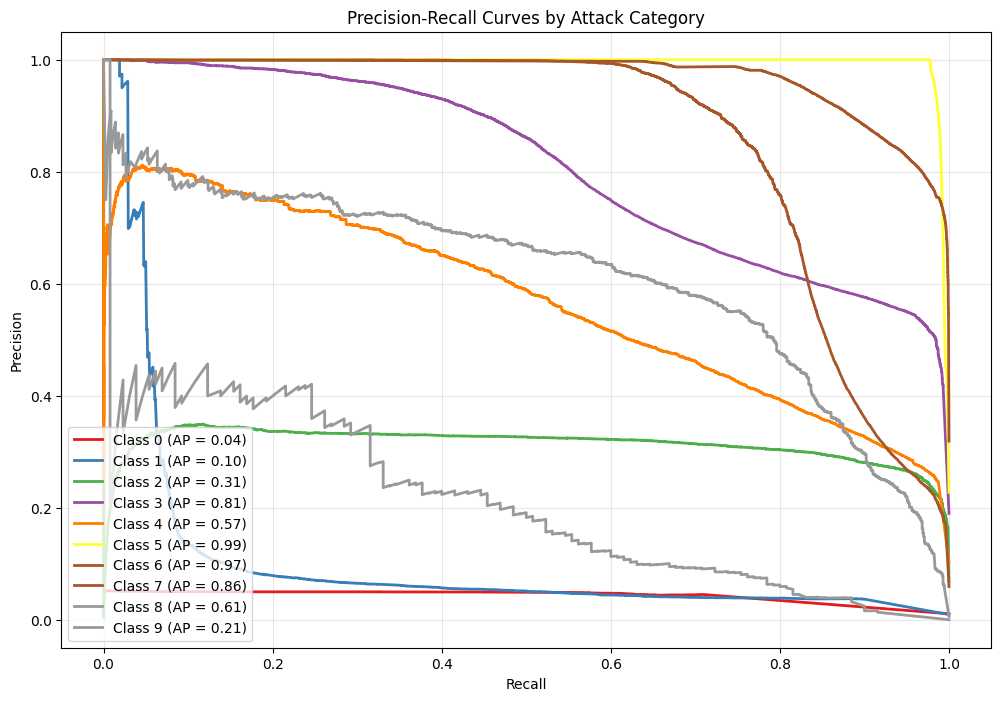

In [18]:

# Precision-Recall curves
n_classes = len(np.unique(y_test))
plot_precision_recall_multiclass(y_test, y_pred_proba, n_classes)


### `plot_feature_importance(model, feature_names, top_n)`

This function identifies and visualizes the most influential features contributing to the model's decisions. By ranking feature importance scores, it highlights which input variables most strongly affect classification outcomes.  

Understanding feature importance offers two key benefits:  
1. Insight into attack mechanisms – it reveals which features are critical for detecting specific attack categories.  
2. Guidance for feature engineering or selection – less relevant features can potentially be removed to simplify the model without sacrificing performance.  

According to *ScienceDirect.com*, some features may hold greater relevance for certain types of attacks than others. This granular understanding helps optimize intrusion detection systems (IDS) by focusing on the attributes that matter most.


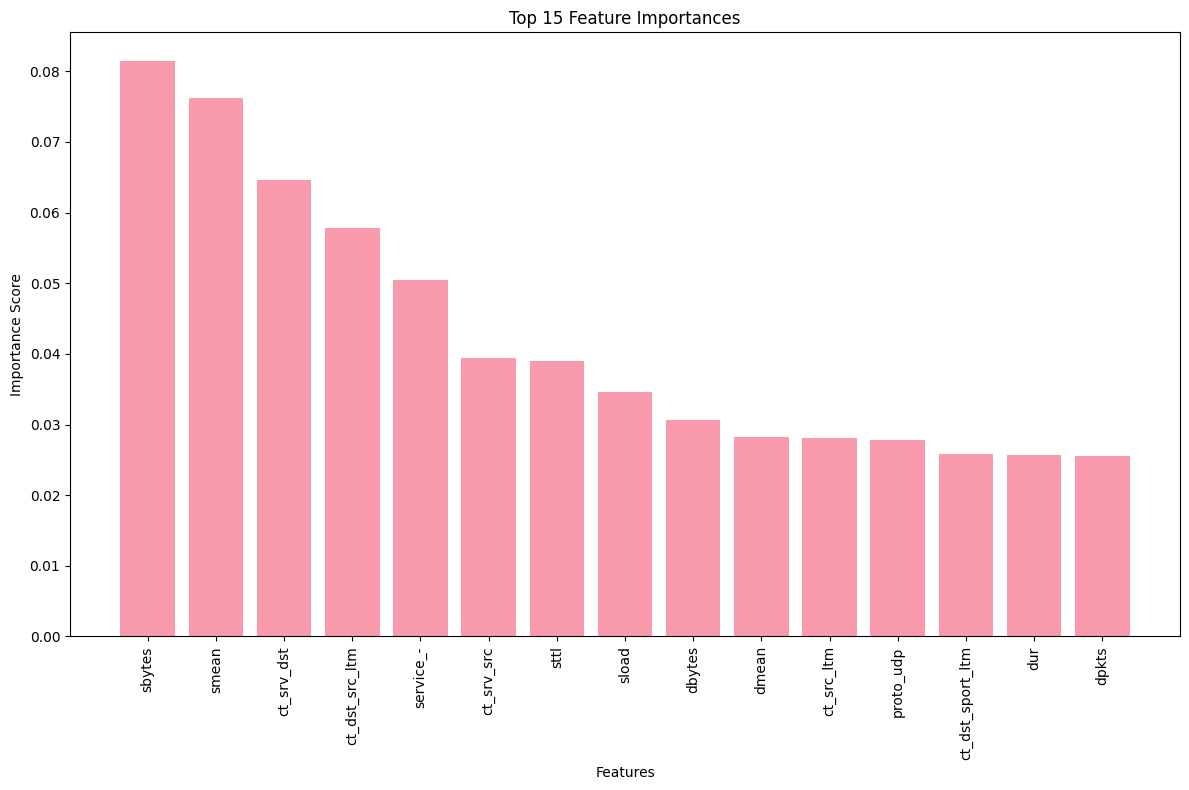

In [19]:

# feature importance
feature_names = X_test.columns.tolist()
plot_feature_importance(model, feature_names, top_n=15)

### `plot_class_distribution_comparison(y_original, y_resampled, class_names)`

This utility visually contrasts the **class distribution before and after** the application of **SMOTE**.  
By showing side-by-side bar plots (or similar visualizations), it provides clear empirical evidence of how SMOTE rebalances the dataset.  

Such visualization is crucial for:  
- Demonstrating the **effectiveness of SMOTE** in addressing class imbalance.  
- Ensuring that the training data no longer favors the majority class disproportionately.  
- Mitigating the risk of bias in the Intrusion Detection System (IDS), enabling fairer and more accurate detection across all attack categories.


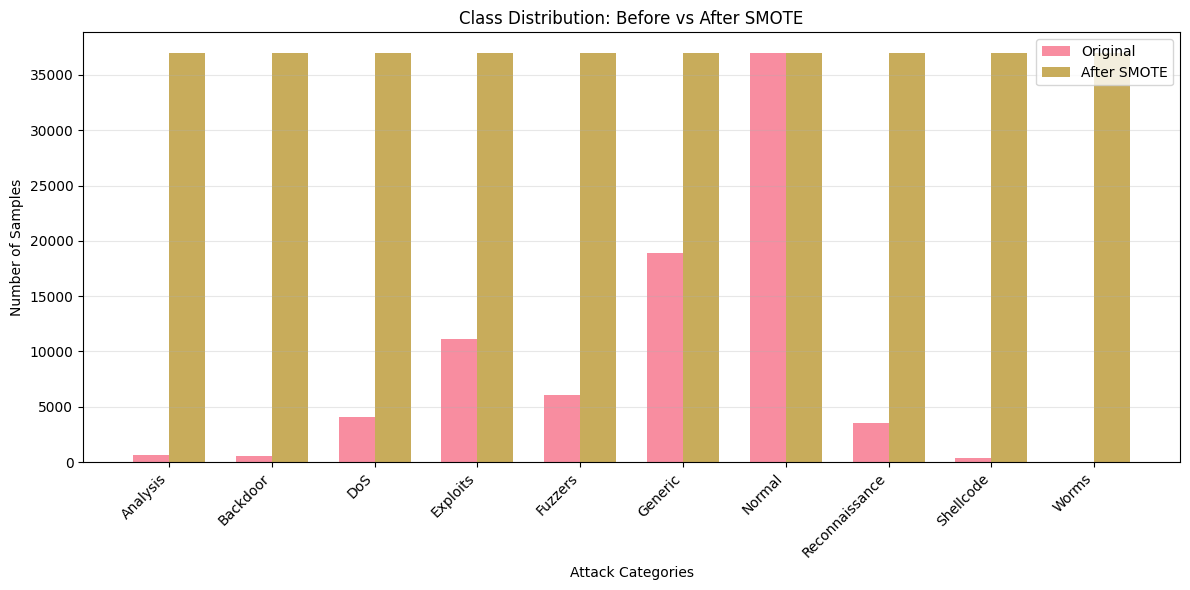

In [20]:
# Class distribution comparison
plot_class_distribution_comparison(y, y_resampled, attack_categories)

### `plot_learning_curves(model, X, y, cv)`

Learning curves plot the **model's performance** on both the **training set** and the **cross-validation set** as a function of the training set size.  

This diagnostic tool is particularly useful for:  
- Detecting **high bias (underfitting)**, where both training and validation scores remain low.  
- Detecting **high variance (overfitting)**, where training scores are high but validation scores lag significantly behind.  
- Determining whether the model would benefit from **more data**, **feature engineering**, or **increased/decreased model complexity**.

In [ ]:

# Learning curves
plot_learning_curves(model, X_resampled, y_resampled)

## Model Evaluation  

With the model trained and predictions generated, it's time for a rigorous, data-driven assessment.

- **Classification Report** – Summarizes key metrics such as Precision, Recall, and F1-Score for each class, offering a balanced view of performance across all attack categories.  
- **Confusion Matrix** – Provides a granular breakdown of correct and incorrect predictions, revealing misclassifications between specific attack types.  
- **ROC AUC Score** – Measures the classifier’s ability to distinguish between classes, providing a evaluation metric especially valuable in imbalanced datasets.  



Evaluation on the unseen test data (df_test):

Classification Report:
              precision    recall  f1-score   support

           0       0.05      0.11      0.07      2000
           1       0.08      0.17      0.11      1746
           2       0.34      0.53      0.41     12264
           3       0.85      0.51      0.64     33393
           4       0.66      0.23      0.35     18184
           5       0.97      0.98      0.98     40000
           6       0.79      0.97      0.87     56000
           7       0.73      0.77      0.75     10491
           8       0.56      0.74      0.64      1133
           9       0.22      0.43      0.29       130

    accuracy                           0.75    175341
   macro avg       0.53      0.54      0.51    175341
weighted avg       0.78      0.75      0.74    175341


Confusion Matrix:
[[  226   163   885    30    18    58   538    82     0     0]
 [  193   297   955    97    46    26    13   100    17     2]
 [ 1506  1216  6508  1301 

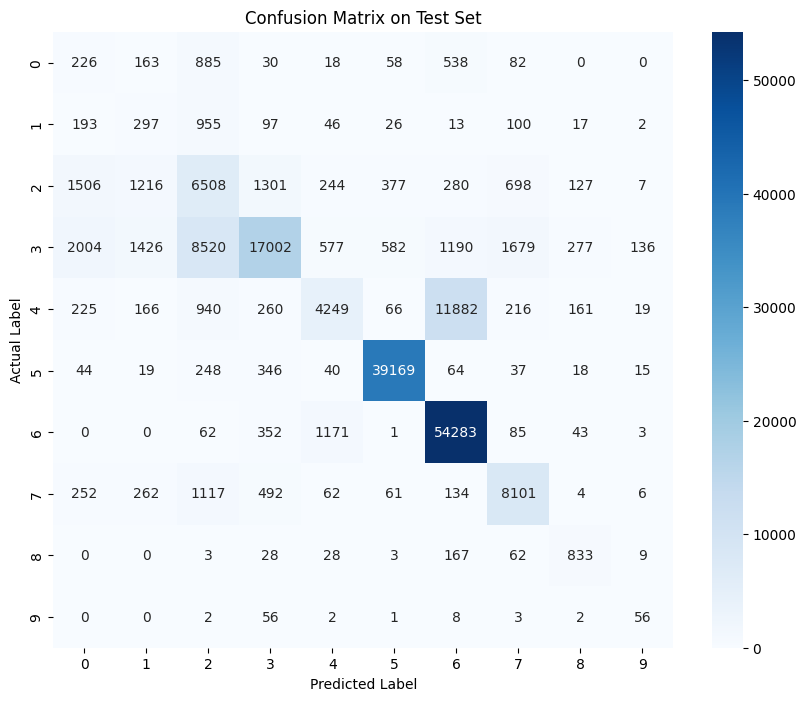


ROC AUC Score (Multi-class): 0.9303


: 

In [ ]:
print("Evaluation on the unseen test data (df_test):")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

print("\nConfusion Matrix:")
cm = confusion_matrix(y_test, y_pred)
print(cm)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix on Test Set')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.show()


try:
    roc_auc = roc_auc_score(y_test, y_pred_proba, multi_class='ovr')
    print(f"\nROC AUC Score (Multi-class): {roc_auc:.4f}")
except:
    roc_auc = roc_auc_score(y_test, y_pred_proba[:, 1] if y_pred_proba.shape[1] > 1 else y_pred_proba)
    print(f"\nROC AUC Score: {roc_auc:.4f}")